# Distribution of the data related by the following paper: 

### Investigating the effect of grain structure on compressive response of open-cell metal foam using high-fidelity crystal-plasticity modeling 

__Authors:__  _Dongfang Zhao, Kristoffer E. Matheson, Brian R. Phung, Steve Petruzza, Michael W. Czabaj, Ashley D. Spear_ 

__Published in:__  Materials Science and Engineering, Volume 812, 2021, 140847, ISSN 0921-5093

https://doi.org/10.1016/j.msea.2021.140847

https://www.sciencedirect.com/science/article/pii/S0921509321001167

In [1]:
# Pre-requirements: install all the python libraries needed to run this exemple.
# You may need to restart the kernel if the process catches a missing library to be installed. 
import os,sys

# specific prerequisite (this may need to be completed)
!{sys.executable} -m pip  install --upgrade OpenVisus
!{sys.executable} -m OpenVisus configure 

# general prerequisites
!{sys.executable} -m pip install PIL
!{sys.executable} -m pip install urllib
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install mpl_interactions
!{sys.executable} -m pip install ipywidgets
!{sys.executable} -m pip install ipympl 
!{sys.executable} -m pip install ipycanvas
!jupyter.exe nbextension enable --py widgetsnbextension

You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


103843357 Kernel:251 20252:27156 setting VISUS_HOME C:\Users\Valerio\Documents/visus from home directory
103843359 Kernel:341 20252:27156 VERSION GIT_REVISION 982928a VisusHome C:\Users\Valerio\Documents/visus BinaryDirectory c:/users/valerio/appdata/local/programs/python/python38/lib/site-packages/OpenVisus/bin CurrentWorkingDirectory  D:/visus-demo/jupyter
103843360 VisusDbPy:77 20252:27156 Registering PyMultipleDataset
Starting OpenVisus c:\users\valerio\appdata\local\programs\python\python38\lib\site-packages\OpenVisus\__init__.py 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)] sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0) ...
-m OpenVisus configure []
sys.executable c:\users\valerio\appdata\local\programs\python\python38\python.exe is_conda False
Executing command ['c:\\users\\valerio\\appdata\\local\\programs\\python\\python38\\python.exe', '-m', 'pip', 'install', '--upgrade', 'numpy', 'pillow']
Installing PyQt5... 5.12

You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL
You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib
You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\valerio\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import os,sys
from OpenVisus import *
from ipywidgets import *
print(os.getcwd() )

Starting OpenVisus c:\users\valerio\appdata\local\programs\python\python38\lib\site-packages\OpenVisus\__init__.py 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)] sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0) ...
D:\visus-demo\jupyter


In [3]:
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt

def LoadImage(filename):
	if filename.startswith('http'):
		filename=urlopen(filename) 
	return numpy.asarray(Image.open(filename))

def ShowImage(data,width=10):
	ratio=float(data.shape[1])/data.shape[0]
	fig = plt.figure(figsize = (width,width*ratio))
	ax = fig.add_subplot(1,1,1)
	ax.imshow(data, origin='lower')
	plt.show()
    
# function to read data from a remote dataset
# optional parameters: timestep, field (variable in the dataset), logic_box (bounding box of the query), resolution

# Note: the resolution value could sometime fetch a dataset with the wrong aspect ratio, 
# this because in the IDX format we double the size at each resolution on only one of the axis at a time

# function to plot the image data with matplotlib
# optional parameters: colormap, existing plot to reuse (for more interactivity)
def showData(data, cmap=None, plot=None):
    #print(data)
    if(plot==None or cmap!=None):
        width = 6
        ratio=float(data.shape[1])/data.shape[0]
        fig = plt.figure(figsize = (width,width*ratio))
        plot = plt.imshow(data, origin='lower', cmap=cmap)
        plt.show()
        return plot
    else:
        plot.set_data(data)
        plt.show()
        return plot

In [4]:
# create data access method from a dataset stored on the cloud
db=LoadDataset("https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx")

In [5]:
# Create cacheing mechanism
access= db.createAccessForBlockQuery(StringTree.fromString("""
<access type='multiplex'>
        <access type='disk' chmod='rw' url='file://./visus-cache/foam/visus.idx' />
        <access type="CloudStorageAccess" url='https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx' chmod="r" compression="zip" layout="hzorder" /> 
</access>  
"""))

print("The OpenViSUS cache directory is:")
print(os.getcwd() )

The OpenViSUS cache directory is:
D:\visus-demo\jupyter


In [6]:
X_size,Y_size,Z_size = db.getLogicBox()[1]
print(X_size,Y_size,Z_size )
slice_value = int(Z_size/2)
print(db.getFields())

1055 1024 1024
['data', 'dist']


In [7]:
# create a plot for our data
first_query = db.read(x=[slice_value,slice_value+1],y=[0,Y_size],z=[0,Z_size], num_refinements=1 , quality=-3, access = access).reshape([Y_size//2,Z_size//2])

In [8]:
# if running this code in a Jupter notbeook or JupyterLab
%matplotlib notebook 

<IPython.core.display.Javascript object>


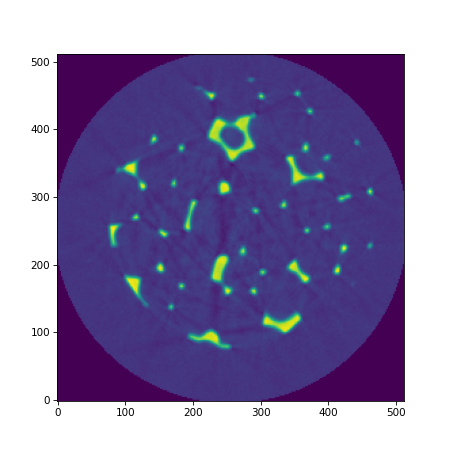

interactive(children=(IntSlider(value=0, description='time', max=3), IntSlider(value=500, description='xslice'…

<function __main__.<lambda>(time, xslice)>

In [9]:
# create a plot for our data
myplot = showData(first_query)
#myplot = None

# function to plot the image data with matplotlib
# optional parameters: colormap, existing plot to reuse (for more interactivity)
def showSlice(time=0,slice_position=700,db=db, cmap=None, plot=myplot):
    global myplot, first_query
    plot = myplot
    print(time,slice_position+1)
    print  (time, 
                    [slice_position,slice_position+1],
                    [0,Y_size],
                    [0,Z_size])
    try:
        data = db.read(time=time, 
                    x=[slice_position,slice_position+1],
                    y=[0,Y_size],
                    z=[0,Z_size], 
                    num_refinements=1 , 
                    quality=-6, 
                    access = access).reshape([Y_size//4,Z_size//4])
    except:
        data = first_query
    first_query = data
    #print(data)
    if(plot==None or cmap!=None):
        print("===================== PROBLEM!!!! =======================================")
        return plot
    else:
        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        plot.set_data(data)
        plt.show()
        return plot

# reuse the plot with an interact for varying time and resolution values
interact(lambda time, xslice: showSlice(time,xslice),
    time  =widgets.IntSlider(value=0,min=0,max=3,step=1),
    xslice=widgets.IntSlider(value=500,min=0,max=1024,step=1))